# Testing Existing IZH Model Implementations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from brian2 import *
import ipywidgets as ipw

### IZH 2007

https://brian2.readthedocs.io/en/stable/examples/frompapers.Izhikevich_2007.html

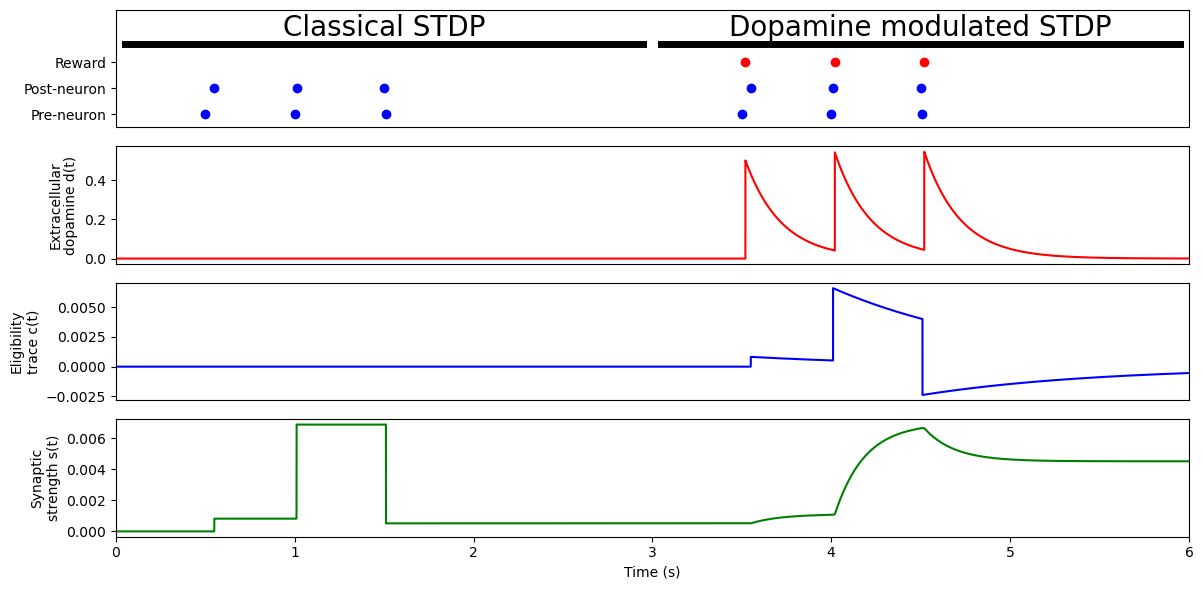

In [1]:
# Below copied from Brian2 
# Parameters
simulation_duration = 6 * second

## Neurons
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

## STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

## Dopamine signaling
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

# Setting the stage

## Stimuli section
input_indices = array([0, 1, 0, 1, 1, 0,
                       0, 1, 0, 1, 1, 0])
input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
spike_input = SpikeGeneratorGroup(2, input_indices, input_times)

neurons = NeuronGroup(2, '''dv/dt = (ge * (Ee-v) + El - v) / taum : volt
                            dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='euler')
neurons.v = vr
neurons_monitor = SpikeMonitor(neurons)

synapse = Synapses(spike_input, neurons,
                   model='''s: volt''',
                   on_pre='v += s')
synapse.connect(i=[0, 1], j=[0, 1])
synapse.s = 100. * mV

## STDP section
synapse_stdp = Synapses(neurons, neurons,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                   on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                   method='euler'
                   )
synapse_stdp.connect(i=0, j=1)
synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0
synapse_stdp_monitor = StateMonitor(synapse_stdp, ['s', 'c', 'd'], record=[0])

## Dopamine signaling section
dopamine_indices = array([0, 0, 0])
dopamine_times = array([3520, 4020, 4520])*ms
dopamine = SpikeGeneratorGroup(1, dopamine_indices, dopamine_times)
dopamine_monitor = SpikeMonitor(dopamine)
reward = Synapses(dopamine, synapse_stdp, model='''''',
                            on_pre='''d_post += epsilon_dopa''',
                            method='exact')
reward.connect()

# Simulation
## Classical STDP
synapse_stdp.mode = 0
run(simulation_duration/2)
## Dopamine modulated STDP
synapse_stdp.mode = 1
run(simulation_duration/2)

# Visualisation
dopamine_indices, dopamine_times = dopamine_monitor.it
neurons_indices, neurons_times = neurons_monitor.it
figure(figsize=(12, 6))
subplot(411)
plot([0.05, 2.95], [2.7, 2.7], linewidth=5, color='k')
text(1.5, 3, 'Classical STDP', horizontalalignment='center', fontsize=20)
plot([3.05, 5.95], [2.7, 2.7], linewidth=5, color='k')
text(4.5, 3, 'Dopamine modulated STDP', horizontalalignment='center', fontsize=20)
plot(neurons_times, neurons_indices, 'ob')
plot(dopamine_times, dopamine_indices + 2, 'or')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])
subplot(412)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular\ndopamine d(t)')
xticks([])
subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])
subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
tight_layout()
show()

### IZH 2003

https://brian2.readthedocs.io/en/stable/examples/frompapers.Izhikevich_2003.html

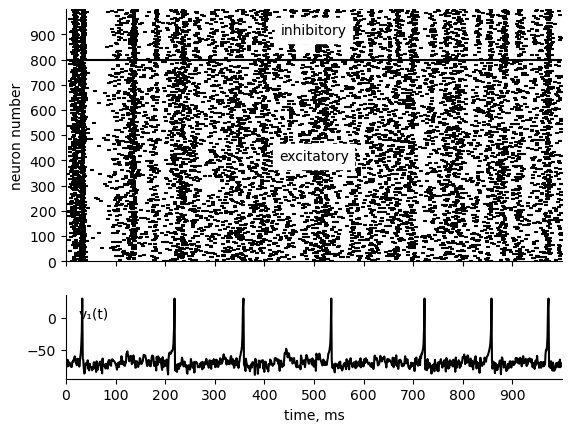

In [18]:
start_scope()

tfinal = 1000 * ms
Ne = 800
Ni = 200

re = np.random.uniform(size=Ne)
ri = np.random.uniform(size=Ni)
weights = np.hstack(
    [
        0.5 * np.random.uniform(size=(Ne + Ni, Ne)),
        -np.random.uniform(size=(Ne + Ni, Ni)),
    ]
).T

defaultclock.dt = 1 * ms

# equations for 2003
eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         I_noise : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

# test equations for 2007
E = -55
eqs_test = """dv/dt = (0.04*v**2 + 5*v + 140 - u*(E-v) + I + I_noise )/ms : 1
              du/dt = (a*(b*v - u))/ms  : 1
              I : 1
              I_noise : 1
              a : 1
              b : 1
              c : 1
              d : 1
           """

# changed eqs to eqs_test here
N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
N.v = -65

N_exc = N[:Ne]
N_inh = N[Ne:]

spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N_exc.a = 0.02
N_exc.b = 0.2
N_exc.c = -65 + 15 * re**2
N_exc.d = 8 - 6 * re**2

N_inh.a = 0.02 + 0.08 * ri
N_inh.b = 0.25 - 0.05 * ri
N_inh.c = -65
N_inh.d = 2

N_exc.u = "b*v"
N_inh.u = "b*v"

S = Synapses(
    N,
    N,
    "w : 1",
    on_pre={"up": "I += w", "down": "I -= w"},
    delay={"up": 0 * ms, "down": 1 * ms},
)
S.connect()
S.w[:] = weights.flatten()

N_exc.run_regularly("I_noise = 5*randn()", dt=1 * ms)
N_inh.run_regularly("I_noise = 2*randn()", dt=1 * ms)

run(tfinal)

fig, (ax, ax_voltage) = plt.subplots(2, 1, sharex=True,
                                     gridspec_kw={'height_ratios': (3, 1)})

ax.scatter(spikemon.t / ms, spikemon.i[:], marker="_", color="k", s=10)
ax.set_xlim(0, tfinal / ms)
ax.set_ylim(0, len(N))
ax.set_ylabel("neuron number")
ax.set_yticks(np.arange(0, len(N), 100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(Ne, color="k")
ax.text(500, 900, 'inhibitory', backgroundcolor='w', color='k', ha='center')
ax.text(500, 400, 'excitatory', backgroundcolor='w', color='k', ha='center')

ax_voltage.plot(statemon.t / ms, np.clip(statemon.v[0], -np.inf, 30),
               color='k')
ax_voltage.text(25, 0, 'v₁(t)')
ax_voltage.set_xticks(np.arange(0, tfinal / ms, 100))
ax_voltage.spines['right'].set_visible(False)
ax_voltage.spines['top'].set_visible(False)
ax_voltage.set_xlabel("time, ms")

plt.show()

### Reimplementing 2003

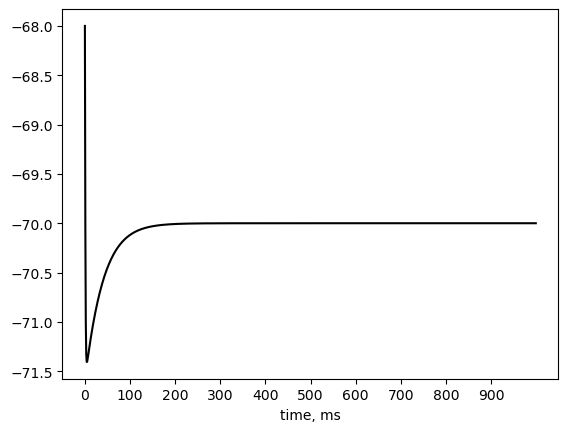

In [23]:
start_scope()

tfinal = 1000 * ms

defaultclock.dt = 1 * ms

eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I)/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

# changed eqs to eqs_test here
N = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
N.v = -65

spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N.a = 0.02
N.b = 0.2
N.c = -65
N.d = 8
N.u = "b*v"

run(tfinal)

plt.plot()
plt.plot(statemon.t / ms, np.clip(statemon.v[0], -np.inf, 30), color='k')
plt.xticks(np.arange(0, tfinal / ms, 100))
plt.xlabel("time, ms")
plt.show()

### J. Etxaniz & I. Urbina's Implementation

Their project: https://julenetxaniz.eus/en/project/spiking-neural-network/

Original publication it was based off of: https://www.izhikevich.org/publications/spikes.htm

In [2]:
# Define default values for the parameters
def model(a=0.02, b=0.2, c=-65, d=2, fI='int(t>100*ms)*10', V=-65, tau=0.25, duration=1000):
    
    # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
        
    defaultclock.dt = tau*ms
    tau = tau/ms
    duration = duration*ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    # Simulation
    # Add int(t>duration/10) to make v and u constant at the start when I=0
    
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = int(t>duration/10)*tau*a*(b*v-u) : 1
    I : 1
    '''

    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = b*V
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    run(duration)
   
    # Plotting
    plot(M.t/ms, M.v[0], label='v')
    plot(M.t/ms, M.u[0], label='u')
    plot(M.t/ms, M.I[0], label='I')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlabel('Time (ms)')
    ylabel('v, u, I')
    legend()


In [3]:
layout = ipw.Layout(width='100%')
style = {'description_width': 'initial'}
ipw.interact(model,
             a=ipw.FloatSlider(value=0.02, min=-0.03, max=1, step=0.01, continuous_update=False,
                             description="a: time scale of the recovery variable u", style=style, layout=layout),
             b=ipw.FloatSlider(value=0.2, min=-1, max=1, step=0.01, continuous_update=False,
                             description="b: sensitivity of the recovery variable u to the subthreshold fluctuations of the membrane potential v", style=style, layout=layout),
             c=ipw.IntSlider(value=-65, min=-65, max=-45, step=1, continuous_update=False,
                             description="c: after-spike reset value of the membrane potential v", style=style, layout=layout),
             d=ipw.FloatSlider(value=2, min=-2, max=8, step=0.1, continuous_update=False,
                             description="d: after-spike reset of the recovery variable u", style=style, layout=layout),
             fI=ipw.Text(value='int(t/ms>100)*10', continuous_update=False,
                             description="fI: injected dc-current function", style=style, layout=layout),
             V=ipw.FloatSlider(value=-65, min=-87, max=-50, step=1, continuous_update=False,
                             description="V: initial membrane potential v", style=style, layout=layout),
             tau=ipw.FloatSlider(value=0.25, min=0.1, max=1, step=0.01, continuous_update=False,
                             description="tau: time resolution", style=style, layout=layout),
             duration=ipw.IntSlider(value=1000, min=100, max=2000, step=1, continuous_update=False,
                             description="duration: length of the simulation", style=style, layout=layout),
             );


interactive(children=(FloatSlider(value=0.02, continuous_update=False, description='a: time scale of the recov…

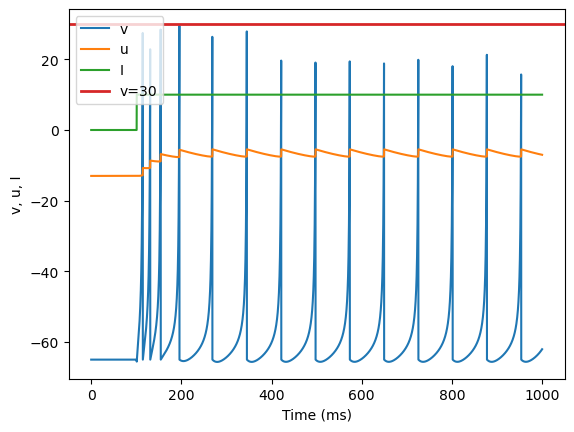

In [4]:
model()

### Excitatory Examples

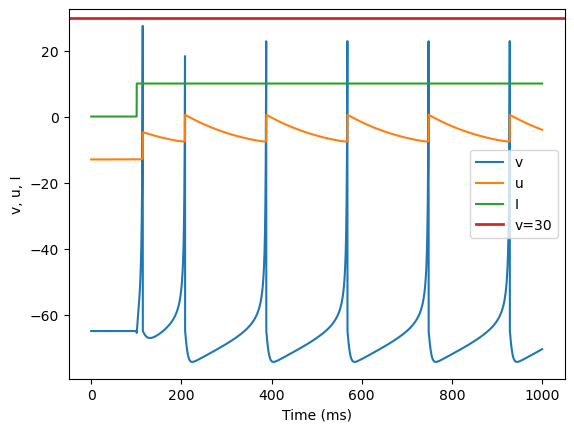

In [5]:
# regular spiking (RS)
model(d=8)

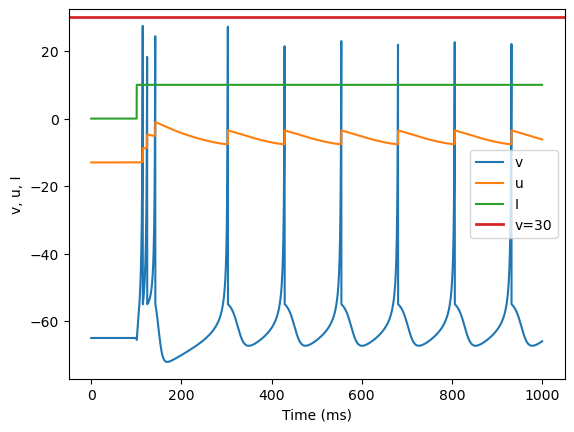

In [6]:
# intrinsically bursting (IB)
model(c=-55, d=4)

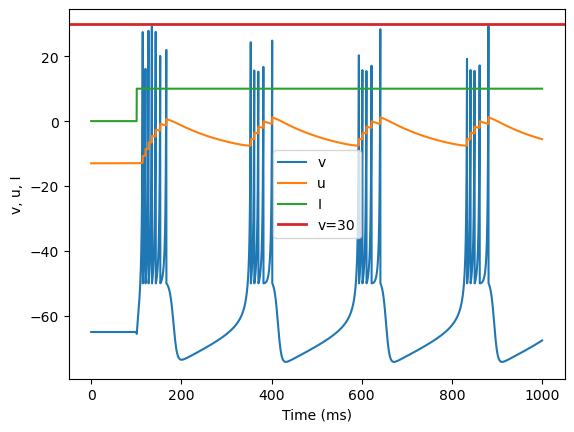

In [7]:
# chattering (C)
model(c=-50)

### Inhibitory Examples

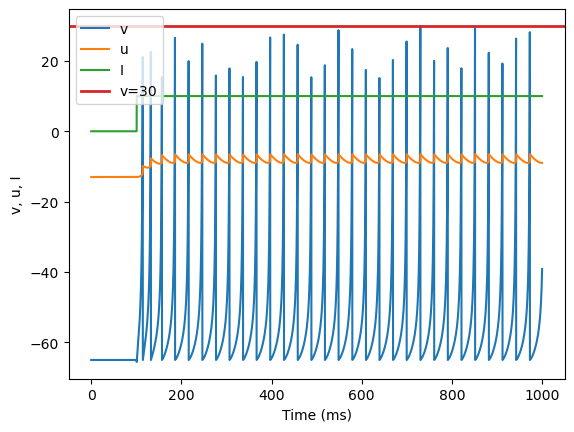

In [8]:
# fast spiking (FS)
model(a=0.1)

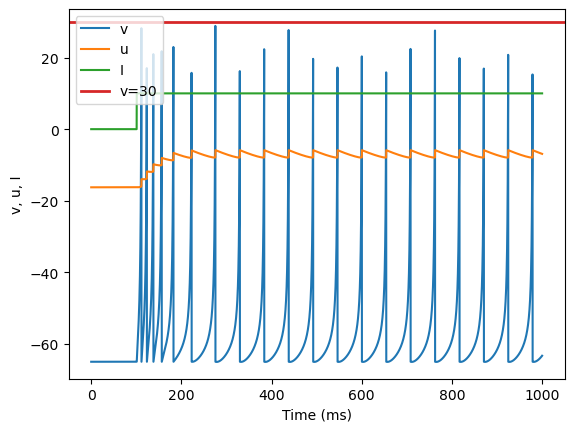

In [9]:
# low-threshold spiking (LTS)
model(b=0.25)

### Other Examples

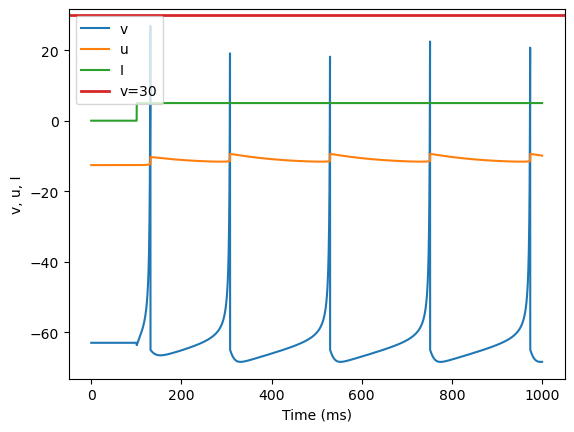

In [11]:
# thalamo-cortical (TC)
model(fI='int(t>100*ms)*5', V=-63)

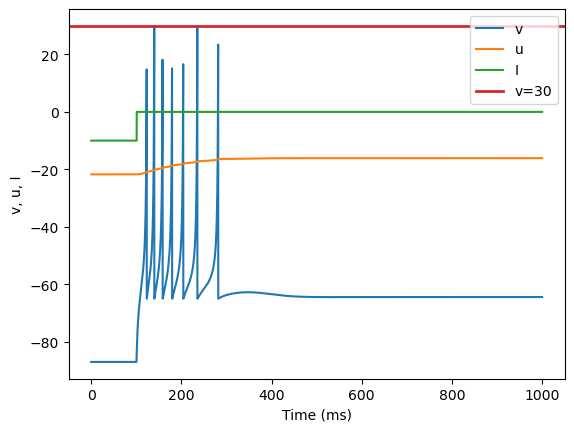

In [12]:
# also TC
model(b=0.25, d=0.05, fI='int(t<=100*ms)*-10', V=-87)

### Neuron Features

Features described in: https://www.izhikevich.org/publications/whichmod.htm

Parameters from: https://www.izhikevich.org/publications/figure1.m 

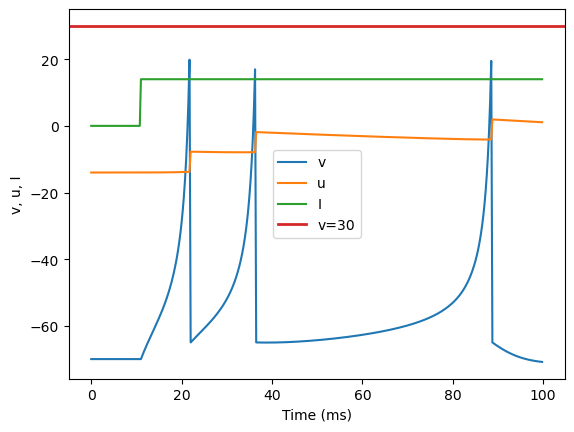

In [13]:
# tonic spiking (A), original parameters
model(d=6, fI='int(t>10*ms)*14', V=-70, tau=0.25, duration=100)

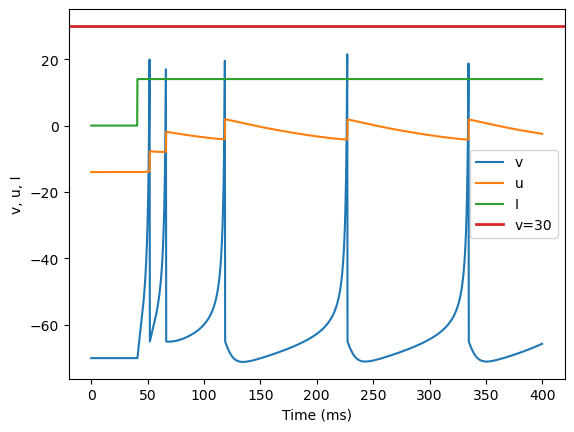

In [14]:
# tonic spiking (A), adjusted parameters
model(d=6, fI='int(t>40*ms)*14', V=-70, tau=0.25, duration=400)

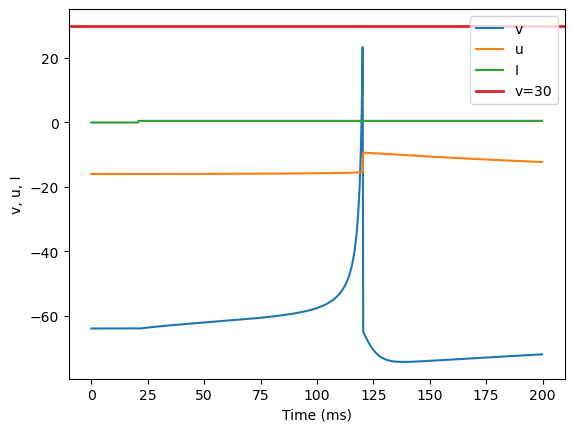

In [15]:
# phasic spiking (B), original parameters
model(b=0.25, d=6, fI='int(t>20*ms)*0.5', V=-64, tau=0.25, duration=200)

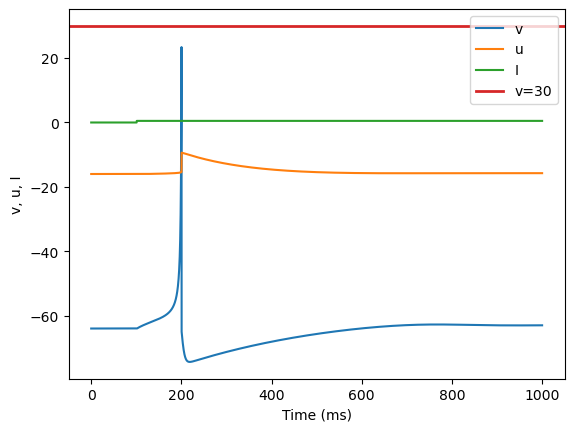

In [16]:
# phasic spiking (B), adjusted parameters
model(b=0.25, d=6, fI='int(t>100*ms)*0.5', V=-64, tau=0.25, duration=1000)

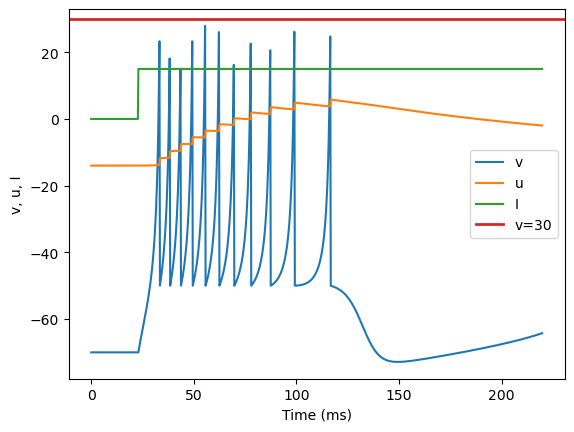

In [17]:
# tonic bursting (C), original parameters
model(c=-50, fI='int(t>22*ms)*15', V=-70, tau=0.25, duration=220)

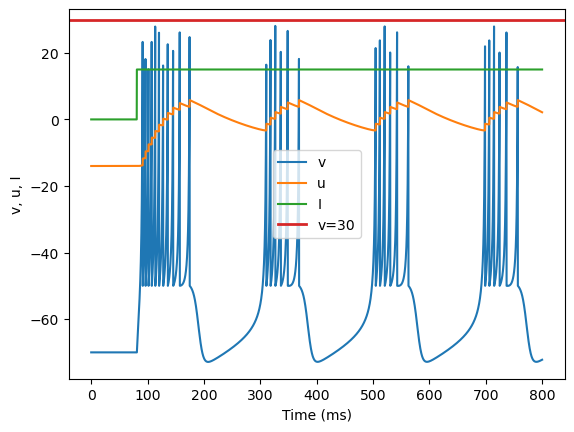

In [18]:
# tonic bursting (C), adjusted parameters
model(c=-50, fI='int(t>80*ms)*15', V=-70, tau=0.25, duration=800)

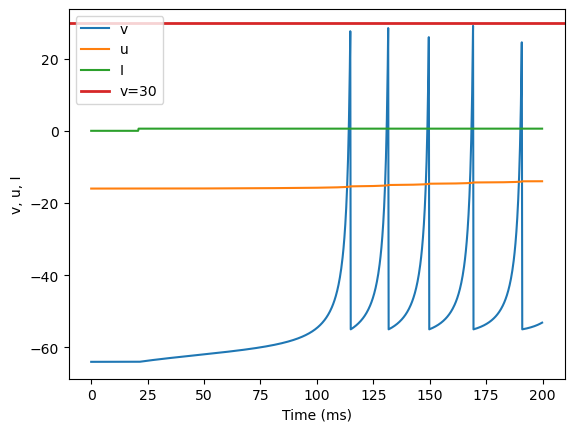

In [19]:
# phasic bursting (D), original parameters
model(b=0.25, c=-55, d=0.05, fI='int(t>20*ms)*0.6', V=-64, tau=0.2, duration=200)

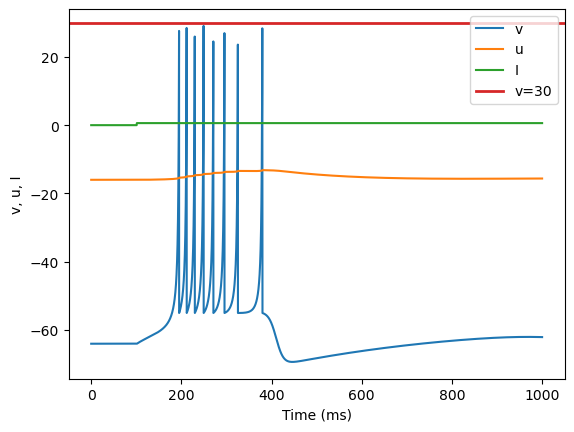

In [20]:
# phasic bursting (D), adjusted parameters
model(b=0.25, c=-55, d=0.05, fI='int(t>100*ms)*0.6', V=-64, tau=0.2, duration=1000)

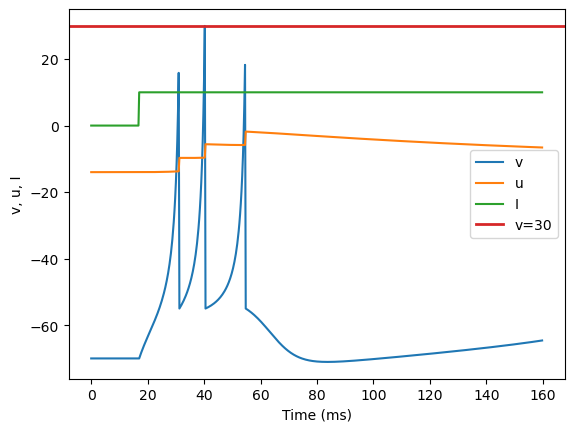

In [21]:
# mixed mode (E), original parameters
model(c=-55, d=4, fI='int(t>16*ms)*10', V=-70, tau=0.25, duration=160)

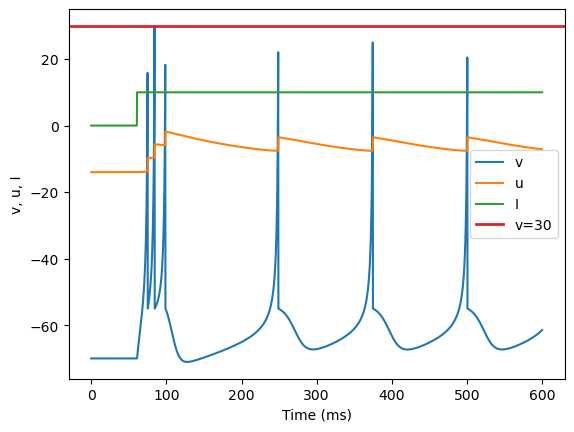

In [22]:
# mixed mode (E), adjusted parameters
model(c=-55, d=4, fI='int(t>60*ms)*10', V=-70, tau=0.25, duration=600)

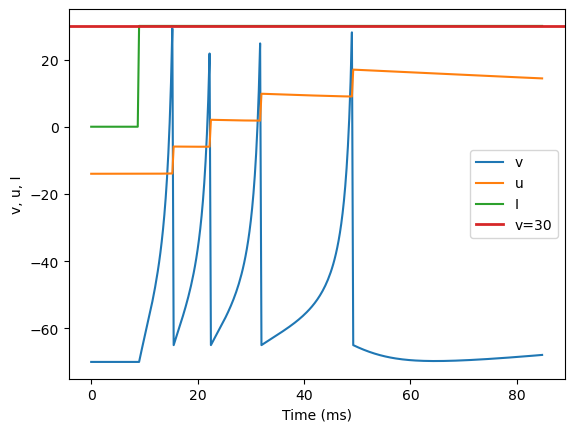

In [23]:
# spike frequency adaptation (F), original parameters
model(a=0.01, d=8, fI='int(t>8.5*ms)*30', V=-70, tau=0.25, duration=85)

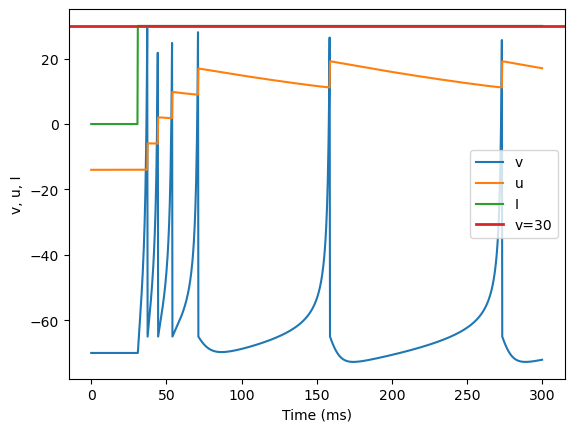

In [24]:
# spike frequency adaptation (F), adjusted parameters
model(a=0.01, d=8, fI='int(t>30*ms)*30', V=-70, tau=0.25, duration=300)

In [25]:
# The original model is changed: (0.04*V^2+4.1*V+108-u+I) it will be necessary to copy it
def model2(a=0.02, b=0.2, c=-65, d=2, fI='int(t>100*ms)*10', V=-65, tau=0.25, duration=1000):
    
    # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
    
    defaultclock.dt = tau*ms
    tau = tau/ms
    duration = duration*ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    
    # Simulation
    # We added int(t>duration/10) to make v and u constant at the start when I=0
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+4.1*v+108-u+I) : 1
    du/dt = int(t>duration/10)*tau*a*(b*v-u) : 1
    I : 1
    '''
    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = b*V
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    run(duration)
   
    # Plotting
    plot(M.t/ms, M.v[0], label='v')
    plot(M.t/ms, M.u[0], label='u')
    plot(M.t/ms, M.I[0], label='I')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlabel('Time (ms)')
    ylabel('v, u, I')
    legend()


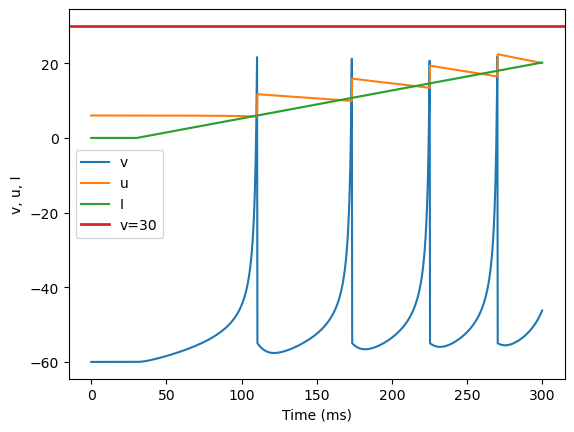

In [26]:
# class 1 excitable (G), original parameters
model2(b=-0.1, c=-55, d=6, fI='int(t>30*ms)*0.075*(t/ms-30)', V=-60, tau=0.25, duration=300)

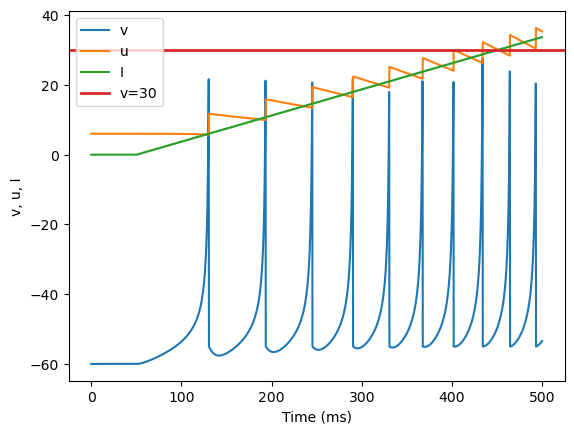

In [27]:
# class 1 excitable (G), adjusted parameters
model2(b=-0.1, c=-55, d=6, fI='int(t>50*ms)*0.075*(t/ms-50)', V=-60, tau=0.25, duration=500)

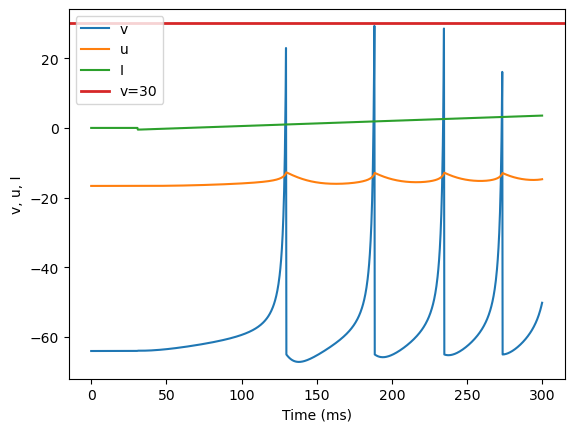

In [28]:
# class 2 excitable (H), original parameters
model(a=0.2, b=0.26, d=0, fI='int(t>30*ms)*(-0.5+0.015*(t/ms-30))', V=-64, tau=0.25, duration=300)

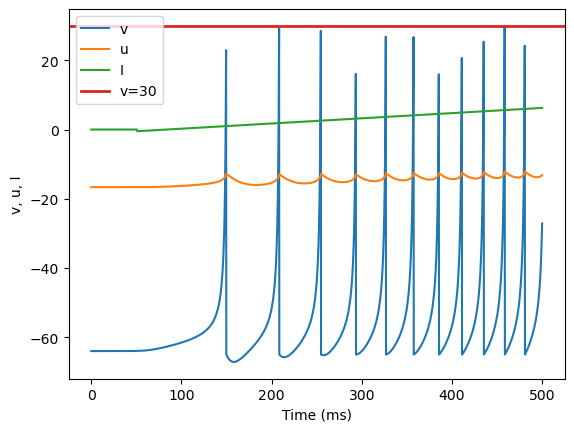

In [29]:
# class 2 excitable (H), adjusted parameters
model(a=0.2, b=0.26, d=0, fI='int(t>50*ms)*(-0.5+0.015*(t/ms-50))', V=-64, tau=0.25, duration=500)

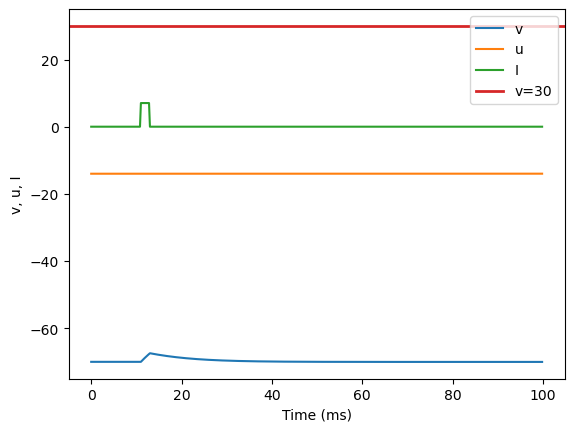

In [30]:
# spike latency (I), original parameters
model(d=6, fI='int(t>10*ms and t<13*ms)*7.04', V=-70, tau=0.2, duration=100)

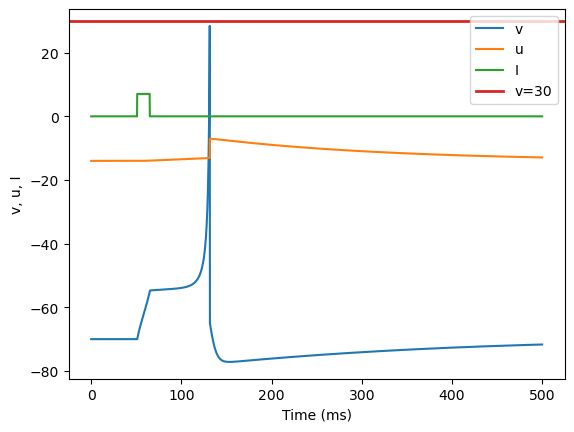

In [31]:
# spike latency (I), adjusted parameters
model(d=6, fI='int(t>50*ms and t<65*ms)*7.04', V=-70, tau=0.2, duration=500)

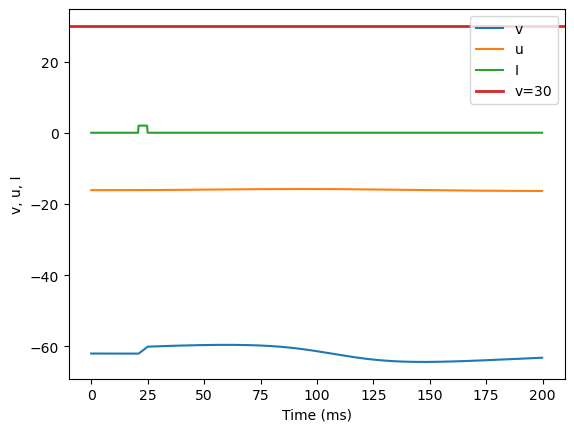

In [32]:
# subthreshold oscillations (J), original parameters
model(a=0.05, b=0.26, c=-60, d=0, fI='int(t>20*ms and t<25*ms)*2', V=-62, tau=0.25, duration=200)

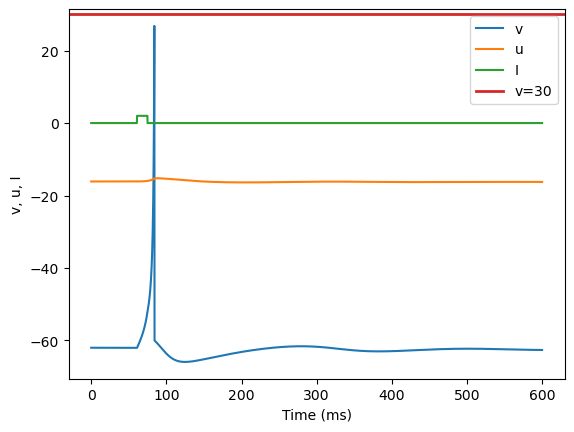

In [33]:
# subthreshold oscillations (J), adjusted parameters
model(a=0.05, b=0.26, c=-60, d=0, fI='int(t>60*ms and t<75*ms)*2', V=-62, tau=0.25, duration=600)

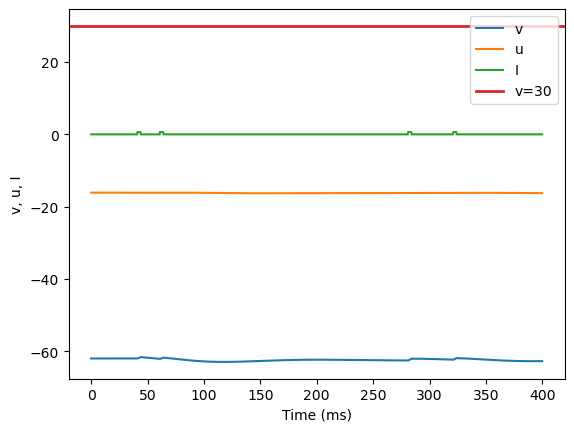

In [34]:
# resonator (K), original parameters
model(a=0.1, b=0.26, c=-60, d=-1, fI='int(t>40*ms and t<44*ms or t>60*ms and t<64*ms or t>280*ms and t<284*ms or t>320*ms and t<324*ms)*0.65', V=-62, tau=0.25, duration=400)

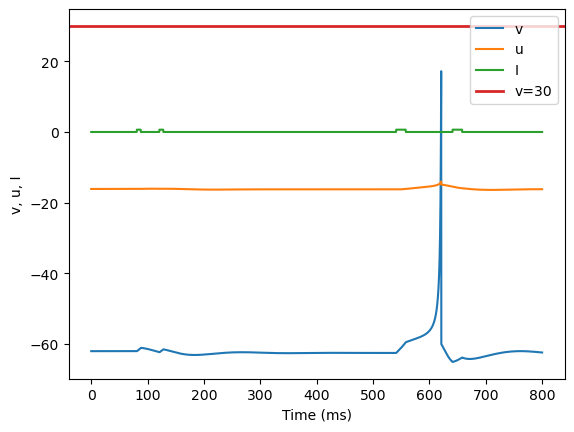

In [35]:
# resonator (K), adjusted parameters (needs adjusting)
model(a=0.1, b=0.26, c=-60, d=-1, fI='int(t>80*ms and t<88*ms or t>120*ms and t<128*ms or t>540*ms and t<558*ms or t>640*ms and t<658*ms)*0.65', V=-62, tau=0.25, duration=800)

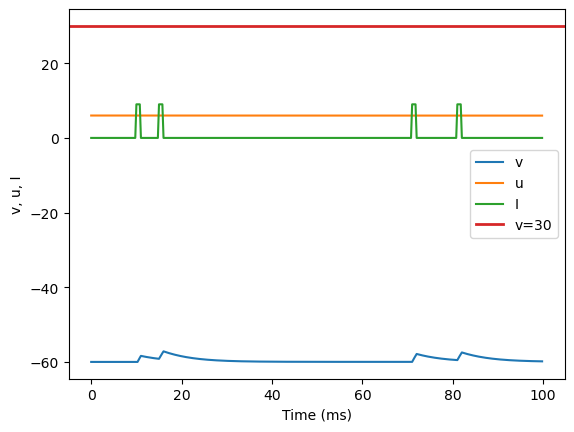

In [36]:
# integrator (L), original parameters
model2(b=-0.1, c=-55, d=6, fI='int(t>9*ms and t<11*ms or t>14*ms and t<16*ms or t>70*ms and t<72*ms or t>80*ms and t<82*ms)*9', V=-60, tau=0.25, duration=100)

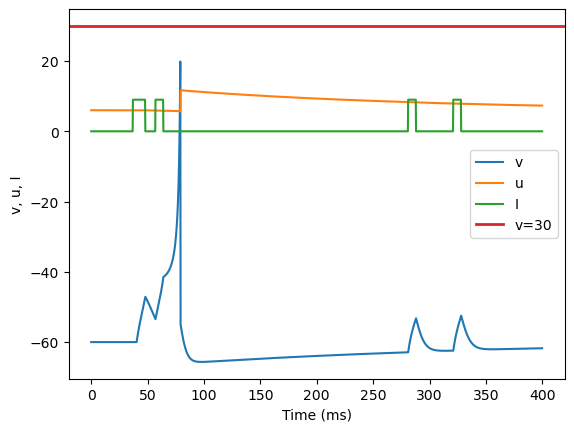

In [37]:
# integrator (L), adjusted parameters
model2(b=-0.1, c=-55, d=6, fI='int(t>36*ms and t<48*ms or t>56*ms and t<64*ms or t>280*ms and t<288*ms or t>320*ms and t<328*ms)*9', V=-60, tau=0.25, duration=400)

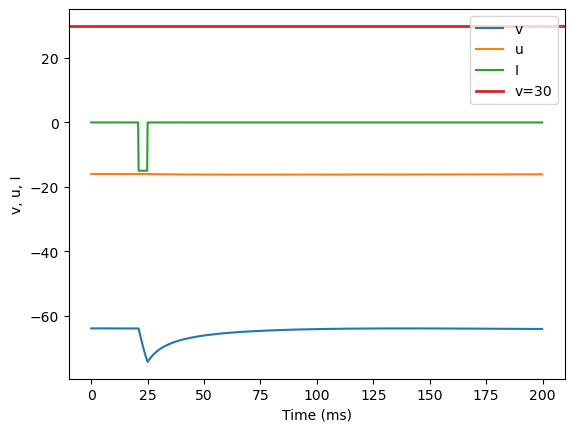

In [38]:
# rebound spike (M), original parameters
model(a=0.03, b=0.25, c=-60, d=4, fI='int(t>20*ms and t<25*ms)*-15', V=-64, tau=0.2, duration=200)

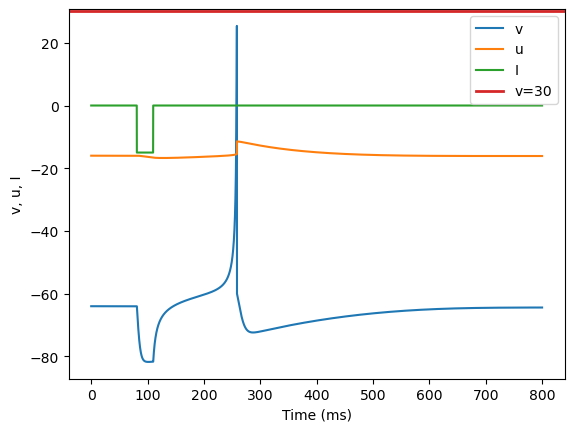

In [39]:
# rebound spike (M), adjusted parameters
model(a=0.03, b=0.25, c=-60, d=4, fI='int(t>80*ms and t<110*ms)*-15', V=-64, tau=0.2, duration=800)

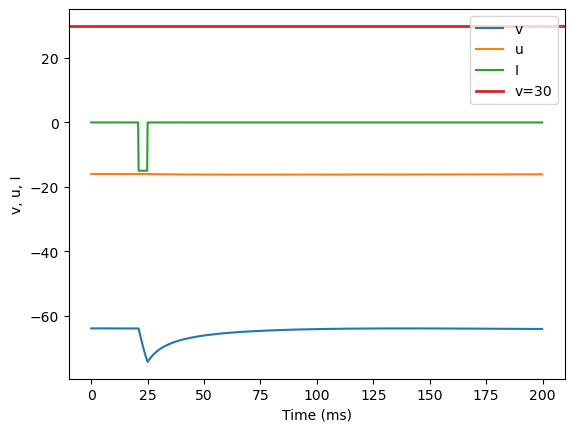

In [40]:
# rebound burst (N), original parameters
model(a=0.03, b=0.25, c=-52, d=0, fI='int(t>20*ms and t<25*ms)*-15', V=-64, tau=0.2, duration=200)

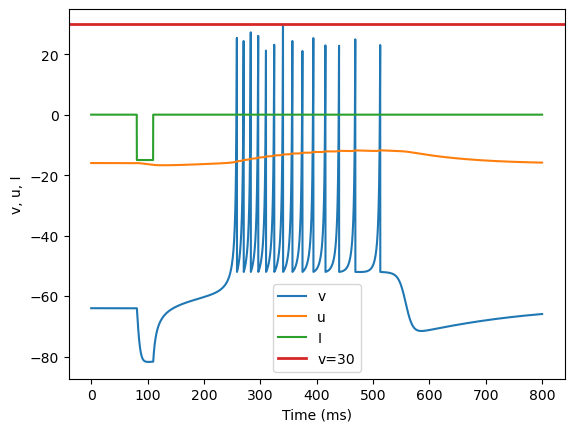

In [41]:
# rebound burst (N), adjusted parameters
model(a=0.03, b=0.25, c=-52, d=0, fI='int(t>80*ms and t<110*ms)*-15', V=-64, tau=0.2, duration=800)

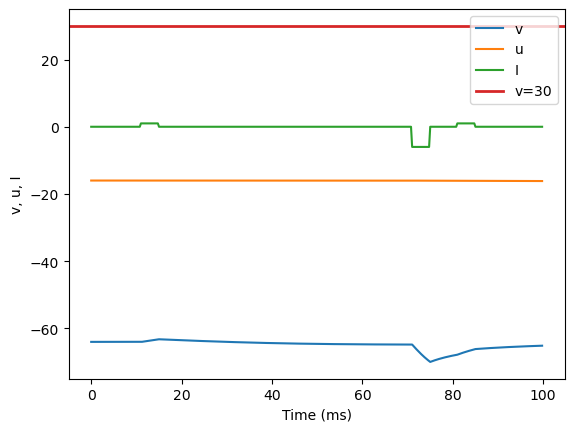

In [42]:
# threshold variability (O), original parameters
model(a=0.03, b=0.25, c=-60, d=4, fI='int(t>10*ms and t<15*ms or t>80*ms and t<85*ms)*1 + int(t>70*ms and t<75*ms)*-6', V=-64, tau=0.25, duration=100)

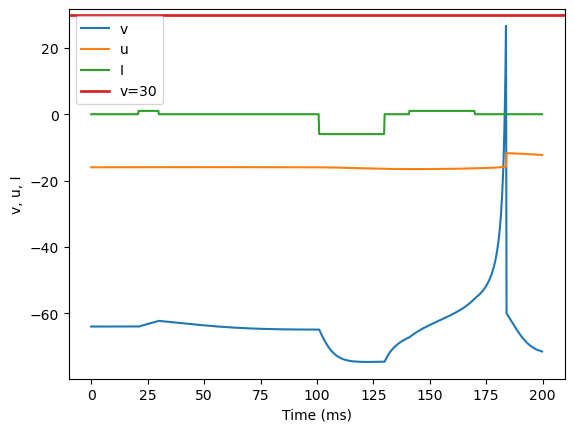

In [43]:
# threshold variability (O), adjusted parameters (needs adjusting: first and third I have to be the same length)
model(a=0.03, b=0.25, c=-60, d=4, fI='int(t>20*ms and t<30*ms or t>140*ms and t<170*ms)*1 + int(t>100*ms and t<130*ms)*-6', V=-64, tau=0.25, duration=200)

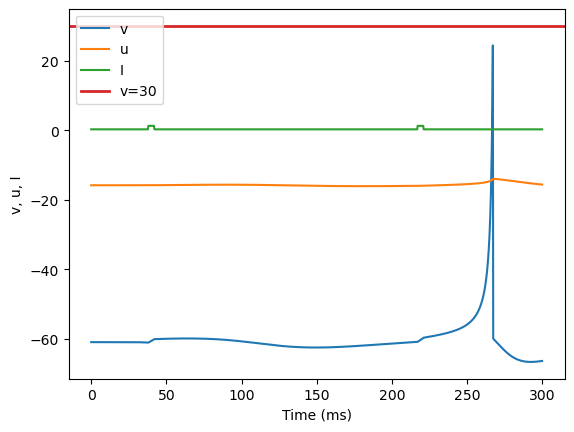

In [44]:
# bistability (P), original parameters
model(a=0.1, b=0.26, c=-60, d=0, fI='int(t>37*ms and t<42*ms or t>216*ms and t<221*ms)*1.24 + int(t<=37*ms or t>=42*ms and t<=216*ms or t>=221*ms)*0.24', V=-61, tau=0.25, duration=300)

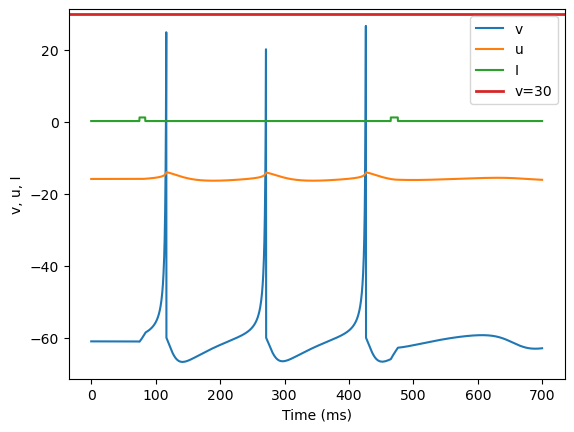

In [45]:
# bistability (P), adjusted parameters
model(a=0.1, b=0.26, c=-60, d=0, fI='int(t>74*ms and t<84*ms or t>464*ms and t<476*ms)*1.24 + int(t<=74*ms or t>=84*ms and t<=464*ms or t>=476*ms)*0.24', V=-61, tau=0.25, duration=700)

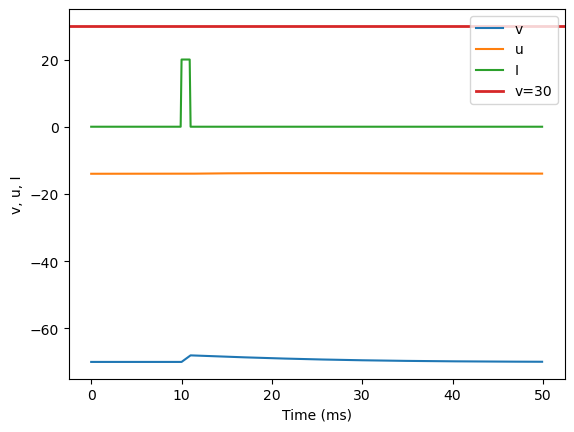

In [46]:
# depolarizing after-potential (Q), original parameters
model(a=1, c=-60, d=-21, fI='int(t>9*ms and t<11*ms)*20', V=-70, tau=0.1, duration=50)

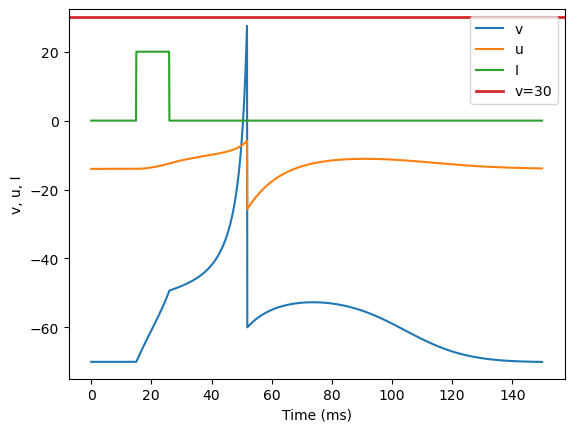

In [47]:
# depolarizing after-potential (Q), adjusted parameters
model(a=1, c=-60, d=-20, fI='int(t>15*ms and t<26*ms)*20', V=-70, tau=0.1, duration=150)

In [48]:
# The model has to be changed to set u=-16 amd remove v and
def model3(a=0.02, b=0.2, c=-65, d=2, fI='int(t>100*ms)*10', V=-65, tau=0.25, duration=1000):
    
     # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
        
  
    defaultclock.dt = tau*ms
    tau = tau/ms
    duration = duration*ms
    
    # Simulation
    # Remove int(t>duration/10) to update u and v from the start
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    eqs = '''
    dv/dt = tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = tau*a*(b*v-u) : 1
    I : 1
    '''
    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = -16
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    run(duration)
   
    # Plotting
    plot(M.t/ms, M.v[0], label='v')
    plot(M.t/ms, M.u[0], label='u')
    plot(M.t/ms, M.I[0], label='I')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlabel('Time (ms)')
    ylabel('v, u, I')
    legend()


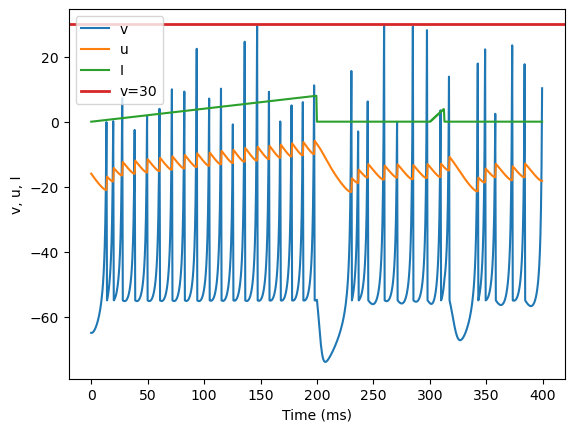

In [49]:
# accomodation (R), original parameters
model3(b=1, c=-55, d=4, fI='int(t<200*ms)*t/ms/25 + int(t>=300*ms and t<312.5*ms)*(t/ms-300)/12.5*4', V=-65, tau=0.5, duration=400)

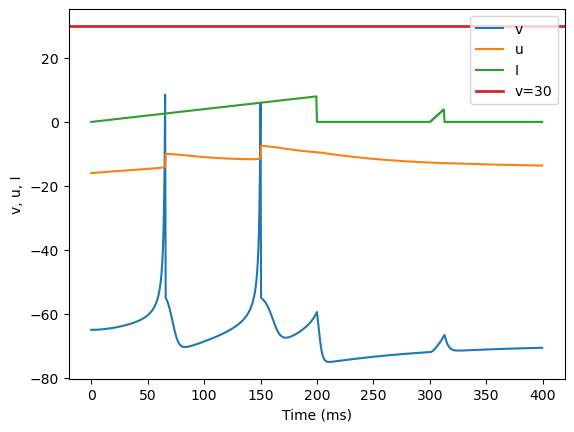

In [50]:
# accomodation (R), adjusted parameters (needs adjusting)
model3(b=0.2, c=-55, d=4, fI='int(t<200*ms)*t/ms/25 + int(t>=300*ms and t<312.5*ms)*((t/ms-300)/12.5*4)', V=-65, tau=0.5, duration=400)

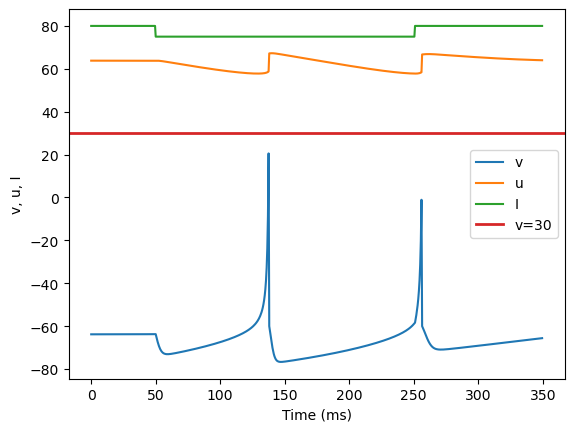

In [51]:
# inhibition induced spiking (S), original parameters
model(a=-0.02, b=-1, c=-60, d=8, fI='int(t<50*ms or t>250*ms)*80 + int(t>=50*ms and t<=250*ms)*75', V=-63.8, tau=0.5, duration=350)

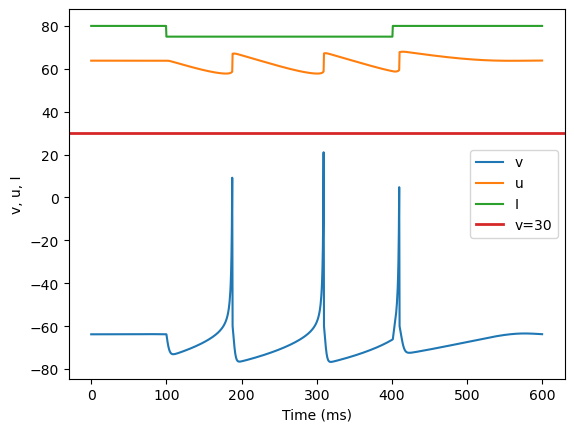

In [52]:
# inhibition induced spiking (S), adjusted parameters
model(a=-0.02, b=-1, c=-60, d=8, fI='int(t<100*ms or t>400*ms)*80 + int(t>=100*ms and t<=400*ms)*75', V=-63.8, tau=0.5, duration=600)

In [53]:
# Define default values for the parameters
def model4(a=0.02, b=0.2, c=-65, d=2, fI='int(t>100*ms)*10', V=-65, tau=0.25, duration=1000):
    
     # Parameters:
        # a: describes the time scale of the recovery variable u.
        # b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
        #    of the membrane potential v.
        # c: describes the after-spike reset value of the membrane potential v.
        # d: describes after-spike reset of the recovery variable u.
        # fI: function that defines the value of I through time.
        # V: initial value of the membrane potential.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
    
    defaultclock.dt = tau*ms
    tau = tau/ms
    duration = duration*ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    
    # Simulation
    # Add int(t>duration/10) to make v and u constant at the start when I=0
    eqs = '''
    dv/dt = int(t>duration/10)*tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = int(t>duration/10)*tau*a*(b*v-u) : 1
    I : 1
    '''
    # Create a NeuronGroup with one neuron using previous equations
    G = NeuronGroup(1, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Set initial values of v and u
    G.v = V
    G.u = b*V
    
    # Create a monitor to record v, u and I values
    M = StateMonitor(G, ('v', 'u', 'I'), record=0)
    
    # Set I value every 1*ms with the parameter function fI
    @network_operation(dt=1*ms)
    def change_I():
        G.I = fI
    
    # Run the simulation for duration time
    run(duration)
   
    # Plotting
    plot(M.t/ms, M.v[0], label='v')
    # u has to be removed for visualization
    #plot(M.t/ms, M.u[0], label='u')
    plot(M.t/ms, M.I[0], label='I', c='C2')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlabel('Time (ms)')
    ylabel('v, u, I')
    legend()


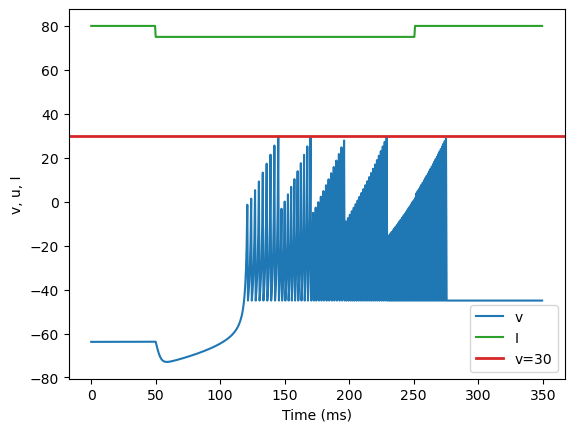

In [54]:
# inhibition induced bursting (T), original parameters
model4(a=-0.026, b=-1, c=-45, d=-2, fI='int(t<50*ms or t>250*ms)*80 + int(t>=50*ms and t<=250*ms)*75', V=-63.8, tau=0.5, duration=350)

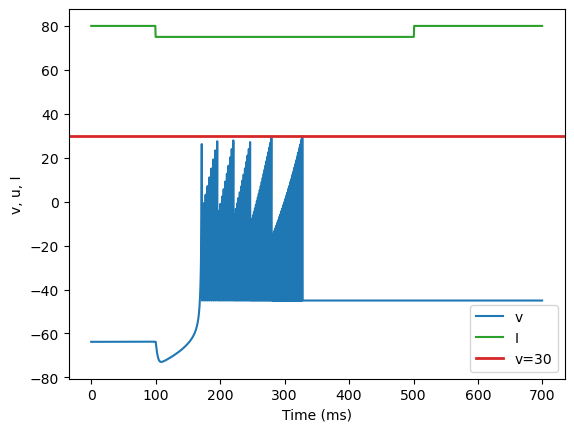

In [55]:
# inhibition induced bursting (T), adjusted parameters (needs more adjusting)
model4(a=-0.026, b=-1, c=-45, d=-2, fI='int(t<100*ms or t>500*ms)*80 + int(t>=100*ms and t<=500*ms)*75', V=-63.8, tau=0.5, duration=700)

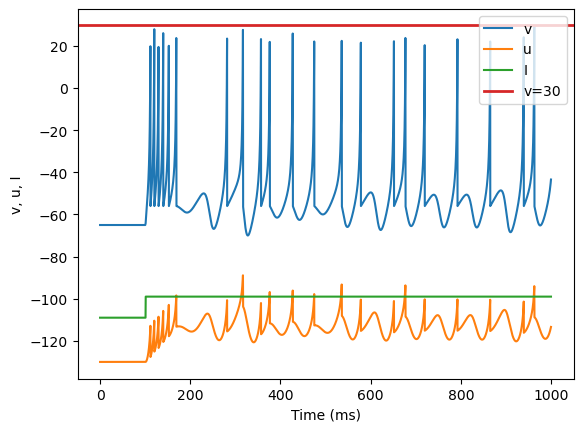

In [56]:
# chaos (U)
model(a=0.2, b=2, c=-56, d=-16, fI='int(t>100*ms)*-99 + int(t<=100*ms)*-109', tau=0.2, duration=1000)

### Simulation

Originally proproposed here: https://www.izhikevich.org/publications/net.m (1000 neurons, 800 excitatory and 200 inhibitory, run for 1000ms but doesn't use strict types - instead values calculated randomly to resemble real variability)

In [57]:
def simulation(Ne=800, Ni=200, tau=1, duration=1000):
    
    # Parameters:
        # Ne: excitatory neurons quantity.
        # Ni: inhibitory neurons quantity.
        # tau: dv/dt and du/dt equations correspond to the change in a concrete time interval 
        #      that variables v and u suffer. This concrete time interval is defined by the value tau.
        # duration: defines the duration of the simulation.
    
    defaultclock.dt = 0.1*ms
    tau = tau/ms
    duration = duration*ms
    
    # Two behaviour differential equations:
    #    1) dv/dt: represents the membrane potential evolution during time.
    #    2) du/dt: represents the membrane recovery variable evolution during time.
    
    # Independent variables:
    #    1) I: represents the input current.
    #    2) v: represents the membrane potential of the neuron.
    #    3) u: represents a membrane recovery variable which provides negative feedback to v. This feedback
    #          is caused due to activation of K+ ionic currents and inactivation of Na+ ionic currents.
    #    4) a: describes the time scale of the recovery variable u.
    #    5) b: describes the sensitivity of the recovery variable u to the subthreshold fluctuations
    #          of the membrane potential v.
    #    6) c: describes the after-spike reset value of the membrane potential v.
    #    7) d: describes after-spike reset of the recovery variable u.
    
    eqs = '''
    dv/dt = tau*(0.04*v**2+5*v+140-u+I) : 1
    du/dt = tau*a*(b*v-u) : 1
    I : 1
    a : 1
    b : 1
    c : 1
    d : 1
    '''
    
    # Excitatory neurons group network. Quantity of Ne (800)
    Ge = NeuronGroup(Ne, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    # Inhibitory neurons group network. Quantity of Ni (200)
    Gi = NeuronGroup(Ni, eqs, threshold='v>=30', reset='v=c; u+=d', method='euler')
    
    # Initial values of excitatory neurons parameters a, b, c, d, v and u 
    Ge.a = 0.02
    Ge.b = 0.2
    Ge.c = '-65+15*rand()**2'
    Ge.d = '8-6*rand()**2'
    Ge.v = -65
    Ge.u = Ge.b*-65
    # Initial values of inhibitory neurons parameters a, b, c, d, v and u 
    Gi.a = '0.02+0.08*rand()'
    Gi.b = '0.25-0.05*rand()'
    Gi.c = -65
    Gi.d = 2
    Gi.v = -65
    Gi.u = Gi.b*-65
    
    # Creating synaptical connections between neurons. 4 types of connections:
    #    1) See: a group of excitatory neurons where connections are given by excitatory-excitatory relations
    #    2) Sei: a group of excitatory and inhibitory neurons where connections are given by 
    #             excitatory->inhibitory relations.
    #    3) Sie: a group of excitatory and inhibitory neurons where connections are given by 
    #             inhibitory->excitatory relations.
    #    4) Sii: a group of inhibitory neurons where connections are given by inhibitory-inhibitory relations.
    
    See = Synapses(Ge, Ge, 'w : 1', on_pre='I_post += w')
    See.connect()
    See.w = '0.5*rand()'
    
    Sei = Synapses(Ge, Gi, 'w : 1', on_pre='I_post += w')
    Sei.connect()
    Sei.w = '0.5*rand()'
    
    Sie = Synapses(Gi, Ge, 'w : 1', on_pre='I_post += w')
    Sie.connect()
    Sie.w = '-rand()'
    
    Sii = Synapses(Gi, Gi, 'w : 1', on_pre='I_post += w')
    Sii.connect()
    Sii.w = '-rand()'
    
    # Creating a monitor to measure the values of the first neuron
    Me = StateMonitor(Ge, ('v', 'u', 'I'), record=0)
   
    # Creating monitors that records each NeuronGroup spikes times
    Se = SpikeMonitor(Ge)
    Si = SpikeMonitor(Gi)
    
    # Compute I randomly with normal distribution in each time step
    Ge.run_regularly('I = 5*randn()', dt=tau*ms**2)
    Gi.run_regularly('I = 2*randn()', dt=tau*ms**2)

    # Run the model for a time defined by duration variable
    run(duration)
   
    # Plotting
    figure(figsize=(20, 20))
    # Plot numbers of spiking neurons
    subplot(2,1,1)
    plot(Se.t/ms, Se.i, '.k', ms=3, c='C0', label='Excitatory')
    plot(Si.t/ms, Si.i+Ne, '.k', ms=3, c='C1', label='Inhibitory')
    axhline(Ne, ls='-', c='C2', lw=2, label='Ne')
    xlim(0, duration/ms)
    ylim(0, Ne+Ni)
    xlabel('Time (ms)')
    ylabel('Neuron number')
    title('Numbers of the spiking neurons')
    legend()
    # Plot spikes of first neuron
    subplot(2,1,2)
    plot(Me.t/ms, Me.v[0], label='v')
    plot(Me.t/ms, Me.u[0], label='u')
    plot(Me.t/ms, Me.I[0], label='I')
    axhline(30, ls='-', c='C3', lw=2, label='v=30')
    xlim(0, duration/ms)
    xlabel('Time (ms)')
    ylabel('v, u, I')
    title('v, u and I values of the first neuron')
    legend()


In [58]:
layout = ipw.Layout(width='100%')
style = {'description_width': 'initial'}
ipw.interact(simulation, 
             Ne=ipw.IntSlider(value=800, min=100, max=8000, step=10, continuous_update=False,
                             description="Ne: excitatory neurons quantity", style=style, layout=layout),
             Ni=ipw.IntSlider(value=200, min=100, max=2000, step=10, continuous_update=False,
                             description="Ni: inhibitory neurons quantity", style=style, layout=layout),
             tau=ipw.FloatSlider(value=1, min=0.1, max=2, step=0.01, continuous_update=False,
                             description="tau: time resolution", style=style, layout=layout),
             duration=ipw.IntSlider(value=1000, min=100, max=10000, step=10, continuous_update=False,
                             description="duration: length of the simulation", style=style, layout=layout),
            );


interactive(children=(IntSlider(value=800, continuous_update=False, description='Ne: excitatory neurons quanti…

WARNING    C:\Users\yingy\AppData\Local\Temp\ipykernel_13920\1034245416.py:101: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plot(Se.t/ms, Se.i, '.k', ms=3, c='C0', label='Excitatory')
 [py.warnings]
WARNING    C:\Users\yingy\AppData\Local\Temp\ipykernel_13920\1034245416.py:102: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plot(Si.t/ms, Si.i+Ne, '.k', ms=3, c='C1', label='Inhibitory')
 [py.warnings]


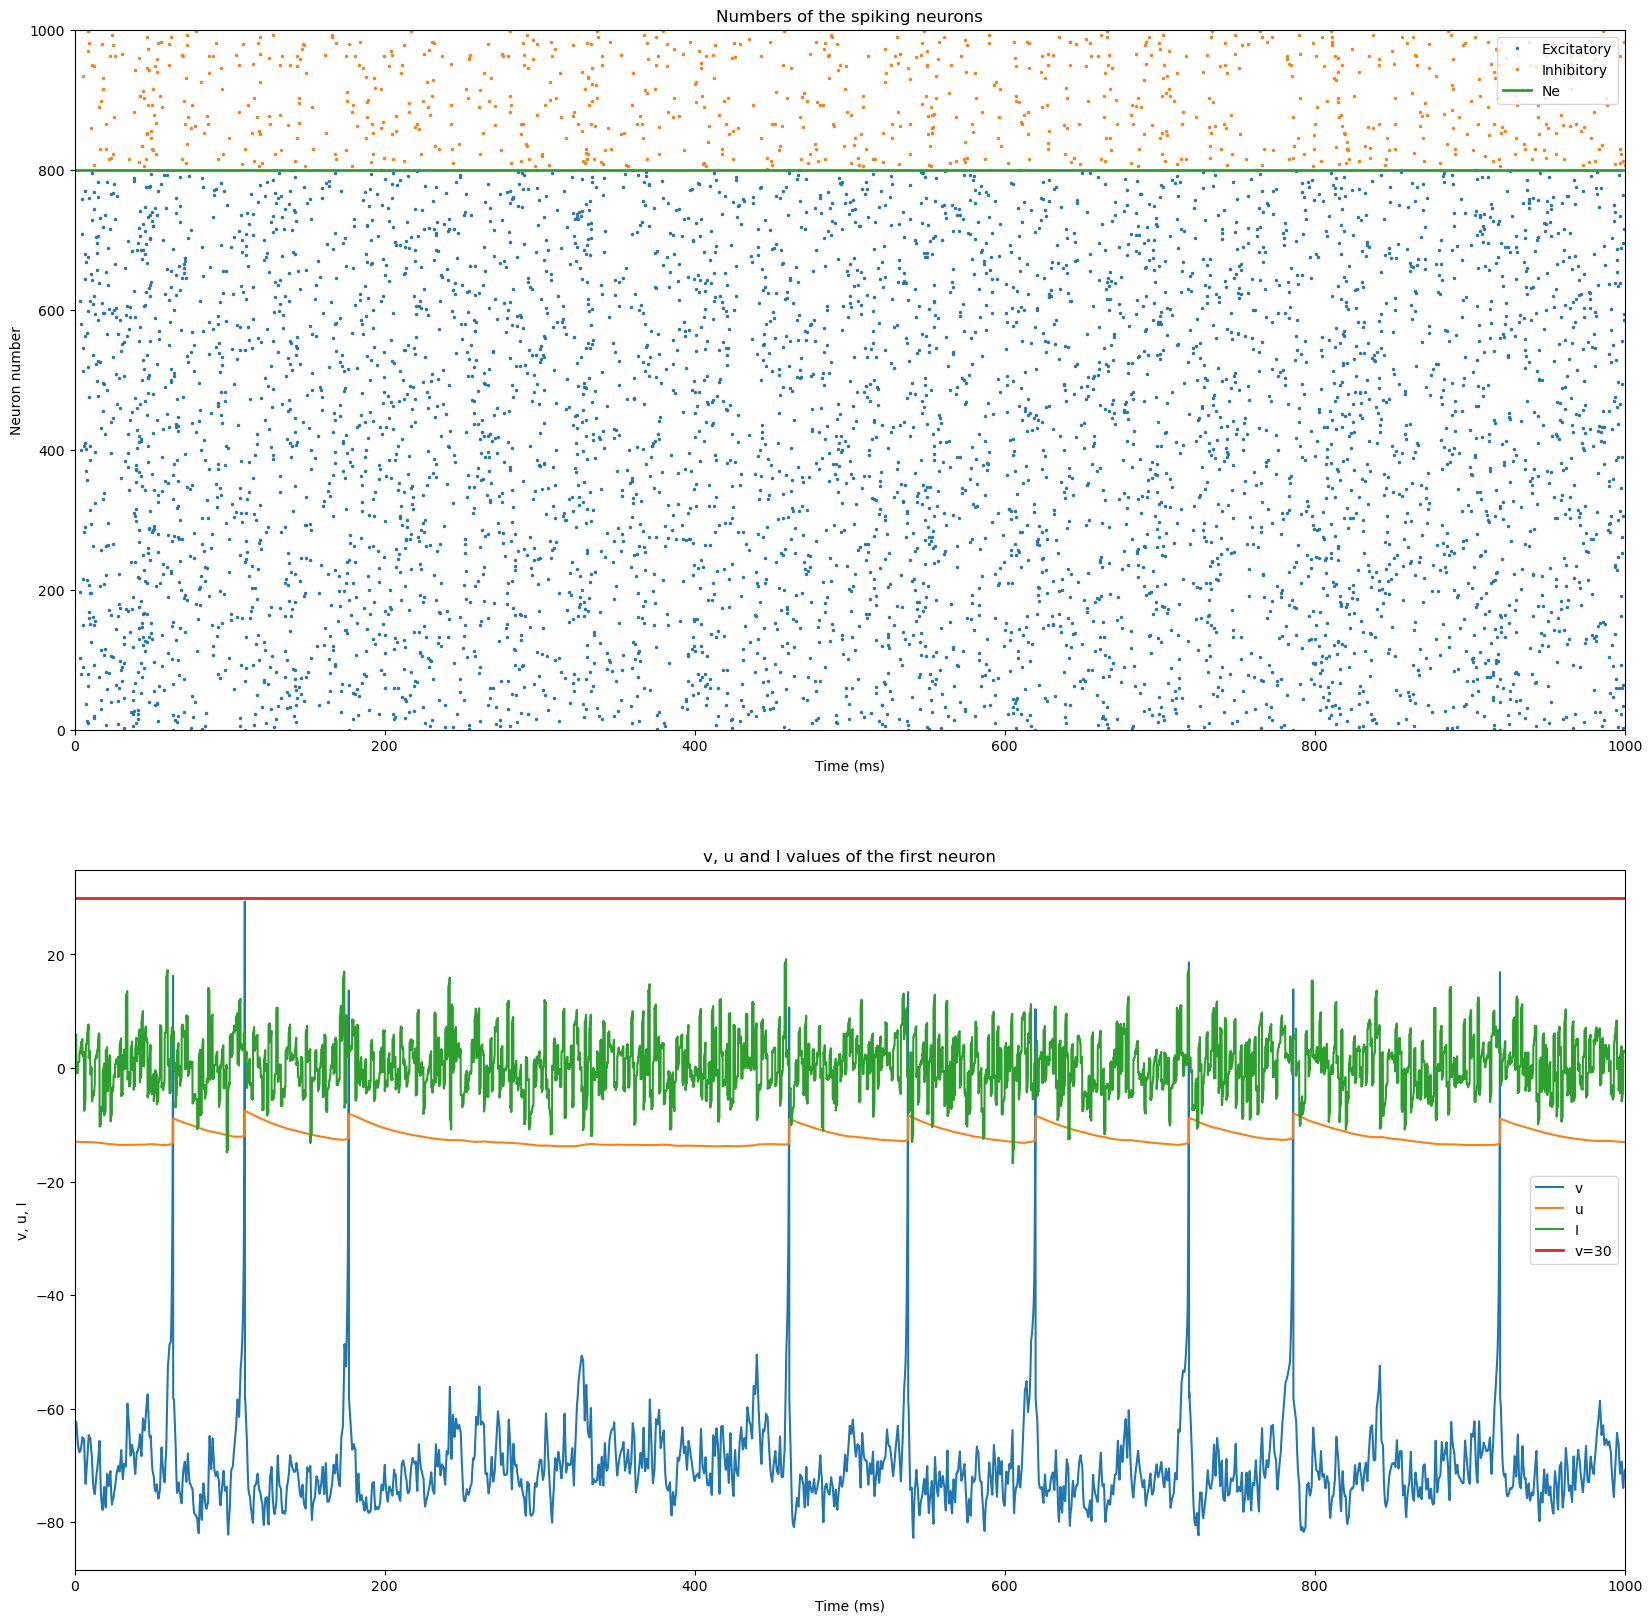

In [59]:
simulation()